In [4]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746500 sha256=50da74cbb8cadfc0fc32b29baf31ac1acc8d6f021870e309d3164ba58ab0bc32
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Karatsuba Algorithm for Fast Multiplication
## Background


The Karatsuba algorithm was developed in 1960 by Anatolii Alexeevitch Karatsuba  to address the inefficiency of traditional long multiplication when dealing with large numbers. Traditional long multiplication has a time complexity of $O(n^2)$ , where $n$ is the number of digits in the numbers being multiplied. As a result, the time required to multiply large numbers grows quadratically, making it impractical for very large inputs.

The algorithm is a fast multiplication algorithm that reduces the number of elementary operations required for multiplying large numbers. It utilizes a divide-and-conquer approach to break down the input numbers into smaller parts and recursively compute the product



## Objective and Task
### Objective
- Compare the performance metrics emprically of Karastuba method with normal multiplication on long integers
### Task
- Implement the Karastuba Algorithm
- Comments on partly parallelized implementations using MPI and check the speedup emprically.






# How Karastuba Algorithm Works

The basic principle of Karatsuba's algorithm is divide-and-conquer, using a formula that allows one to compute the product of two large numbers $x$ and $y$ using three multiplications of smaller numbers, each with about half as many digits as $x$ and $y$  plus some additions and digit shifts.

Let $x$ and $y$ be represented as $n-$digit strings in some base $B$. For any positive integer **$m$** less than $n$, one can write the two given numbers as

$$
x = x_1B^m + x_0\\
y = y_1B^m + y_0
$$

where $x_0$ and $y_0$ are less than $B^m$ . The product is then

$$
    xy = (x_1B^m + x_0)(y_1B^m + y_0) =\\
x_1y_1B^{2m} + (x_1y_0 + x_0y_1)B^m + x_0y_0 = \\
z_2B^{2m} + z_1B^m + z_0\\
$$
$where$

$z_2 = x_1y_1$ ; $z_2 = x_1y_0 +x_0y_1$ ; $z_0 = x_0y_0$.


There are 4 multiplications to the computed here  and later then they get added to gove the result. But Karastuba noticed that the $xy$ terms can be computed using only 3 multiplications, with a little overhead of additions. This is due to the algebraic trick that

\begin{aligned}z_{1}&=x_{1}y_{0}+x_{0}y_{1}\\&=x_{1}y_{0}+x_{0}y_{1}+x_{1}y_{1}-x_{1}y_{1}+x_{0}y_{0}-x_{0}y_{0}\\&=x_{1}y_{0}+x_{0}y_{0}+x_{0}y_{1}+x_{1}y_{1}-x_{1}y_{1}-x_{0}y_{0}\\&=(x_{1}+x_{0})y_{0}+(x_{0}+x_{1})y_{1}-x_{1}y_{1}-x_{0}y_{0}\\&=(x_{1}+x_{0})(y_{0}+y_{1})-x_{1}y_{1}-x_{0}y_{0}\\&=(x_{1}+x_{0})(y_{1}+y_{0})-z_{2}-z_{0}.\\\end{aligned}


Now we need to perform just 3 multiplications at each step with a few more additions. As multiplications is more computational than addition, this will lead to a decrease in the time complexity theoritically.




# Time and Space Complexity of Algorithm

As is the case in several recursive algorithms, the computation will be more effieicent if we divide the computation as evenly as possible. The recursive solution to Karastuba algorithm is most efficient when $m$ equals $\lceil n/2\rceil$

Since addition, subtractions take $O(n)$ time complexity in $n-$ digit numbers, we can estimate recursively the time complexity for the Karastuba algorithm as

$$T(n)=3T(\lceil n/2\rceil )+cn+d$$ , for $c$, $d$ constants.

Using analytical methods , we can get the solution of this recurrence relation to be

$$ T(n)=\Theta (n^{\log _{2}3})\,\!$$, which is much better than the usual multiplication of $T(n)=\Theta (n^2)$ ( from the recurrence $T(n)=4T(\lceil n/2\rceil )+cn+d$, when they would have been 4 multiplcations insted


THe algorithm also has a space complexity of $\Theta(n)\$



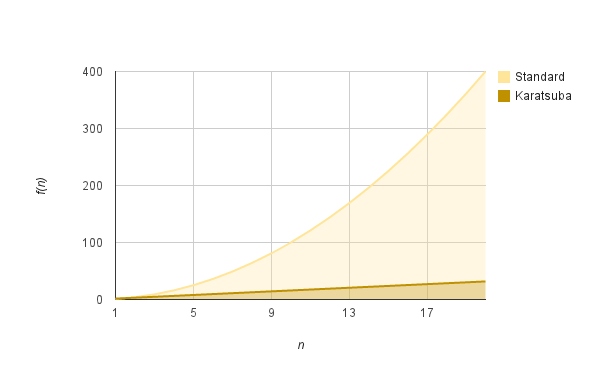

In [28]:
Image('/content/sample_data/Karatsuba-Complexity.png')


### Implementation of Algorithm

In [12]:
# Python implementation of Karatsuba algorithm for bit string multiplication.

# Helper method: given two unequal sized bit strings, converts them to
# same length by adding leading 0s in the smaller string. Returns the
# the new length

def karatsuba(x, y):
    # Base case: if either x or y is a single digit number
    if x < 10 or y < 10:
        return x * y

    # Determine the size of the numbers
    n = max(len(str(x)), len(str(y)))
    m = n // 2

    # Split the numbers into high and low parts
    high1, low1 = divmod(x, 10**m)
    high2, low2 = divmod(y, 10**m)

    # Recursive steps
    z0 = karatsuba(low1, low2)
    z1 = karatsuba((low1 + high1), (low2 + high2))
    z2 = karatsuba(high1, high2)

    # Compute the final product using the Karatsuba formula
    result = (z2 * 10**(2*m)) + ((z1 - z2 - z0) * 10**m) + z0


    return result


from mpi4py import MPI
import math

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def make_equal_length(str1, str2):
    len1 = len(str1)
    len2 = len(str2)
    if len1 < len2:
        for i in range(len2 - len1):
            str1 = '0' + str1
        return len2
    elif len1 > len2:
        for i in range(len1 - len2):
            str2 = '0' + str2
    return len1 # If len1 >= len2

# The main function that adds two bit sequences and returns the addition
def add_bit_strings(first, second):
    result = ""

    length = make_equal_length(first, second)
    carry = 0


    for i in range(length-1, -1, -1):
        first_bit = int(first[i])
        second_bit = int(second[i])

        # boolean expression for sum of 3 bits
        sum = (first_bit ^ second_bit ^ carry) + ord('0')

        result = chr(sum) + result

        # boolean expression for 3-bit addition
        carry = (first_bit & second_bit) | (second_bit & carry) | (first_bit & carry)

    # if overflow, then add a leading 1
    if carry:
        result = '1' + result

    return result

# A utility function to multiply single bits of strings a and b
def multiply_single_bit(a, b):
    return int(a[0]) * int(b[0])

# The main function that multiplies two bit strings X and Y and returns
# result as long integer
def karatsuba_multiply(X, Y):
    X = bin(X)[2:]
    Y = bin(Y)[2:]
    #print(X, Y)
    # Find the maximum of lengths of x and Y and make length
    # of smaller string same as that of larger string
    n = max(len(X), len(Y))
    X = X.zfill(n)
    Y = Y.zfill(n)

    # Base cases
    if n == 0: return 0
    if n == 1: return int(X[0])*int(Y[0])

    fh = n//2 # First half of string
    sh = n - fh # Second half of string

    # Find the first half and second half of first string.
    Xl = X[:fh]
    Xr = X[fh:]
    #print(Xl,Xr)

    # Find the first half and second half of second string
    Yl = Y[:fh]
    Yr = Y[fh:]
    #print(Yl,Yr,int(Xl, 2))


    # Recursively calculate the three products of inputs of size n/2
    P1 = karatsuba_multiply(int(Xl,2), int(Yl,2))
    P2 = karatsuba_multiply(int(Xr,2), int(Yr,2))
    P3 = karatsuba_multiply(int(Xl, 2) + int(Xr, 2), int(Yl, 2) + int(Yr, 2))

    # Combine the three products to get the final result.
    return P1*(1<<(2*sh)) + (P3 - P1 - P2)*(1<<sh) + P2




if __name__ == '__main__':
    print(karatsuba_multiply(45,1311))

    print(karatsuba_multiply(1211,48382))

58995
58590602


Text(0.5, 1.0, 'Emprical Results for testing speed of Karastuba Algorithm')

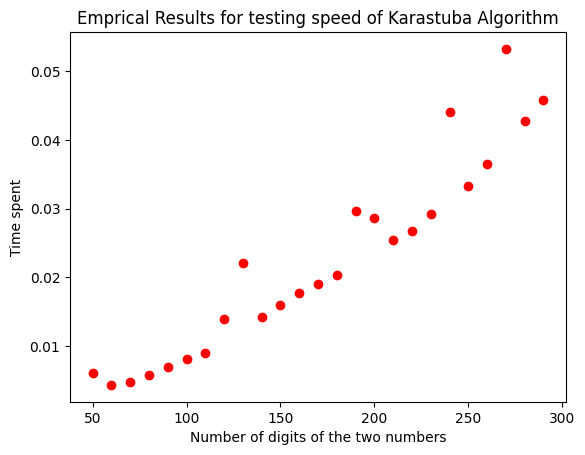

In [18]:
import time
import random

def karatsuba_multiply(x, y):
    # Base case
    if x < 10 or y < 10:
        return x * y

    # Determine the size of the numbers
    n = max(len(str(x)), len(str(y)))
    m = n // 2

    # Split the numbers into high and low parts
    high1, low1 = divmod(x, 10**m)
    high2, low2 = divmod(y, 10**m)

    # Recursive steps
    z0 = karatsuba_multiply(low1, low2)
    z1 = karatsuba_multiply((low1 + high1), (low2 + high2))
    z2 = karatsuba_multiply(high1, high2)

    # Compute the final product using the Karatsuba formula
    result = (z2 * 10**(2*m)) + ((z1 - z2 - z0) * 10**m) + z0
    return result

def normal_multiply(x, y):
    return x*y

# Number of runs for each method
num_runs = 100

# Range of the long integers
#min_value = 10**100
#max_value = 10**200

# Perform the runs and measure the execution time
no_of_digits = []
time_duration = []


def test(min_num_of_digits):

  karatsuba_total_time = 0
  normal_total_time = 0
  max_num_of_digits = 2*min_num_of_digits
  min_value = 10**min_num_of_digits
  max_value = 10**max_num_of_digits

  for _ in range(num_runs):
      x = random.randint(min_value, max_value)
      y = random.randint(min_value, max_value)

      # Measure the execution time for the Karatsuba method
      start_time = time.time()
      karatsuba_multiply(x, y)
      end_time = time.time()
      karatsuba_total_time += end_time - start_time

      # Measure the execution time for normal multiplication
      start_time = time.time()
      normal_multiply(x, y)
      end_time = time.time()
      normal_total_time += end_time - start_time

  # Calculate the average execution time per run
  karatsuba_avg_time = karatsuba_total_time / num_runs
  normal_avg_time = normal_total_time / num_runs
  time_duration.append(karatsuba_avg_time)
  no_of_digits.append(min_num_of_digits)

plt.plot(no_of_digits,time_duration,'ro')
plt.xlabel("Number of digits of the number")
plt.ylabel("Time spent")
plt.title("Emprical Results for testing speed of Karastuba Algorithm")


for x in range (50, 300, 10):
  test(x)


plt.plot(no_of_digits,time_duration,'ro')
plt.xlabel("Number of digits of the two numbers")
plt.ylabel("Time spent")
plt.title("Emprical Results for testing speed of Karastuba Algorithm")


# Print the results
#print("Karatsuba Method Average Time:", karatsuba_avg_time)
#print("Normal Multiplication Average Time:", normal_avg_time)

### Keen Observations

Karastuba Algorithm graph emprically is much better than the quadratic timed naive approach

The 'normal' multiplication seems to run at a quicker time than Karasuba in my simulations.

I found that that python, natively, does not use the normal multiplication when it multiplies large numbers.




   ### Possible Parallelisation of  Karastuba Algorithm on Distributed Memory Application
   
   Since the Karastuba Algorithm is recursive and each computation(recursive multiplication) doesnt depend on data from other parts, we could run several of these recursive calls at same time, if we have some spare processing nodes (or CPUs) at our disposal.

The main concerns to watch out for here are mesage passing bottlenecks, finding an appropriate cut-off level in the recusive stack  and the finding the optimal number of CPU's to reduce the average idle time


We will discuss two possibilities - Master-Slave approach and fork-join approach




## 1) Master - Subordinate Approach

- The master processor launches the Karatsuba algorithm and generates all of the tasks in the tree up to a given level.
- These tasks are forwarded to the subordinate for computation when they have been created seqentially.
- Once the subordinates have completed their calculations, the master process gathers the results and loops around the tree back to the root, merging them to generate the result at a node by combining the results of the previous processes.



###  Implementation

In [ ]:
!pip install mpi4py

In [ ]:
from mpi4py import MPI
import math

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def parallel_karatsuba(x, y):
    if rank == 0:
        result = karatsuba(x, y)
        partial_results = [result]
    else:
        partial_results = None

    local_result = comm.scatter(partial_results, root=0)
    global_result = comm.reduce(local_result, op=MPI.SUM, root=0)

    return global_result

if __name__ == "__main__":
    x = 1234567890
    y = 9876543210

    local_result = parallel_karatsuba(x, y)

    if rank == 0:
        print("The product of", x, "and", y, "is:", local_result)

The message passing bottleneck, which occurs when the number of messages that the master must send sequentially grows at the same pace as the number of processors, is the primary source of this algorithm's efficiency constraint. Recombination of the subresults, which is carried out progressively on the master process, presents another constraint.



## 2) Fork - Join Approach

- One processor begins at the root of the tree and assigns distinct nodes to other processors in a recursive manner.
- Each node assigns three subnodes for the three recursive multiplications and combines the results according to the algebraic trick equation after the three subnodes have completed their computation. (One of the three subtasks should be performed by the parent process, which would otherwise wait idly for the completion of the three subprocesses.)
- When a certain cut-off criterion is reached, no further parallel splitting occurs: the work remaining in a given task is done sequentially.

Both of the parallelisation methods above can speed up the multiplication to $\Theta(n)$ , given a large enough number of processors available (the order of  $\Theta (n^{\log _{2}3})$ processors

## Since many messages will be sent in parallel, there is much less total latency. This will lead to higher speed up compared to the first method, especially when the number of processors gets larger.

However,for this implemetation to be feasible, we will need more computational processors compared to the first one

In [23]:
from google.colab import files
from IPython.display import Image

In [24]:
uploaded = files.upload()

Saving Results.png to Results (1).png


#  Experimental Results (as Implemented on Intel Paragon)

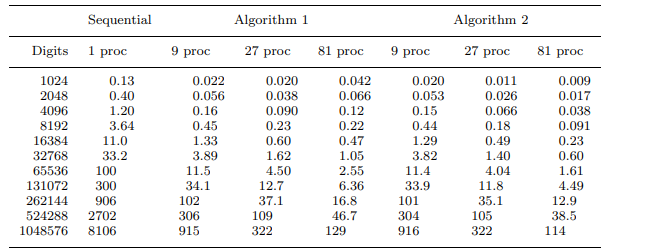

In [25]:
Image("Results.png")


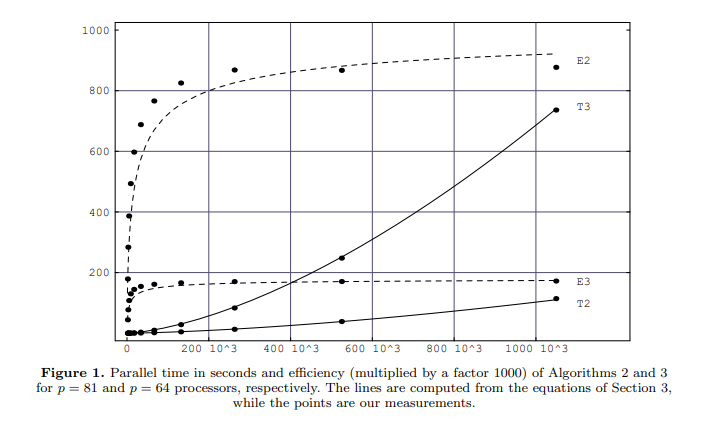

In [27]:
Image("Graph.png")

<img src='./sample_data/Graph.png'/></a>

# References

1. Karatsuba, A., Ofman, Y. (1963). Multiplication of multidigit numbers on automata. Soviet Physics doklady, 7(7):595–596

2. Char, B., Johnson, J., Saunders, D., Wack, A.P. (1994). Some experiments with parallel bignum arithmetic. In Hong, H., (ed.), Proc. 1st International Symposium on Parallel Symbolic Computation,pp. 94–103.

3. Lipson, J. (1984). Elements of Algebra and Algebraic Computing. Benjamin Cumming, Meulo Park,CA.

4. Giovanni C., Roman M. Performance Analysis of the Parallel Karatsuba Multiplication Algorithm for Distributed Memory Architectures Symbolic Computation  21, Issues 4–6, 1996, pp 467-473

5. https://en.wikipedia.org/wiki/Karatsuba_algorithm